In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.particles import rotated_dataset
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    contourplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

save = True

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-08 09:58:59,921 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-08 09:58:59,974 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-08 09:58:59,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-08 09:58:59,975 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-08 09:58:59,975 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-08 09:58:59,976 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-08 09:58:59,976 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-08 09:58:59,977 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-08 09:58:59,977 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-08 09:58:59,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_components"

## CREATE DATA SOURCE

In [7]:
radius = 0.1 * mw.virial_radius()
normal_vector = mw.normal_vector("stars", data=mw.sphere(radius=(10, "kpc")))

In [8]:
sphere_data = mw.sphere(radius=radius)

## METALLICITY IN COMPONENTS

In [9]:
from gallifrey.filter import Filter

filters = Filter(ds)
filters.add_galaxy_components(
    spheroid_circularity_cut=0.2, thin_disk_circularity_cut=0.6, thin_disk_height_cut=1
)
sphere_data = mw.sphere(radius=radius)

yt : [WARNING  ] 2023-09-08 09:59:04,219 The spheroid_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2023-09-08 09:59:04,220 The thin_disk_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2023-09-08 09:59:04,220 The thick_disk_stars particle filter already exists. Overriding.


In [10]:
print("relative occurences, compare with real mw")
np.array(
    [
        len(sphere_data[c, "particle_ones"])
        for c in ["thin_disk_stars", "thick_disk_stars", "spheroid_stars"]
    ]
) / len(sphere_data["stars", "particle_ones"])

relative occurences, compare with real mw


array([0.51403526, 0.30992606, 0.17603868])

In [11]:
def get_columns(col):
    dfs = [
        pd.DataFrame(sphere_data[component, col], columns=[component]).melt(
            var_name="component", value_name=col
        )
        for component in ["thin_disk_stars", "thick_disk_stars", "spheroid_stars"]
    ]
    return pd.concat(dfs)


data = get_columns("[Fe/H]")
data["circularity"] = get_columns("circularity")["circularity"]

(-2.5, 1.0)

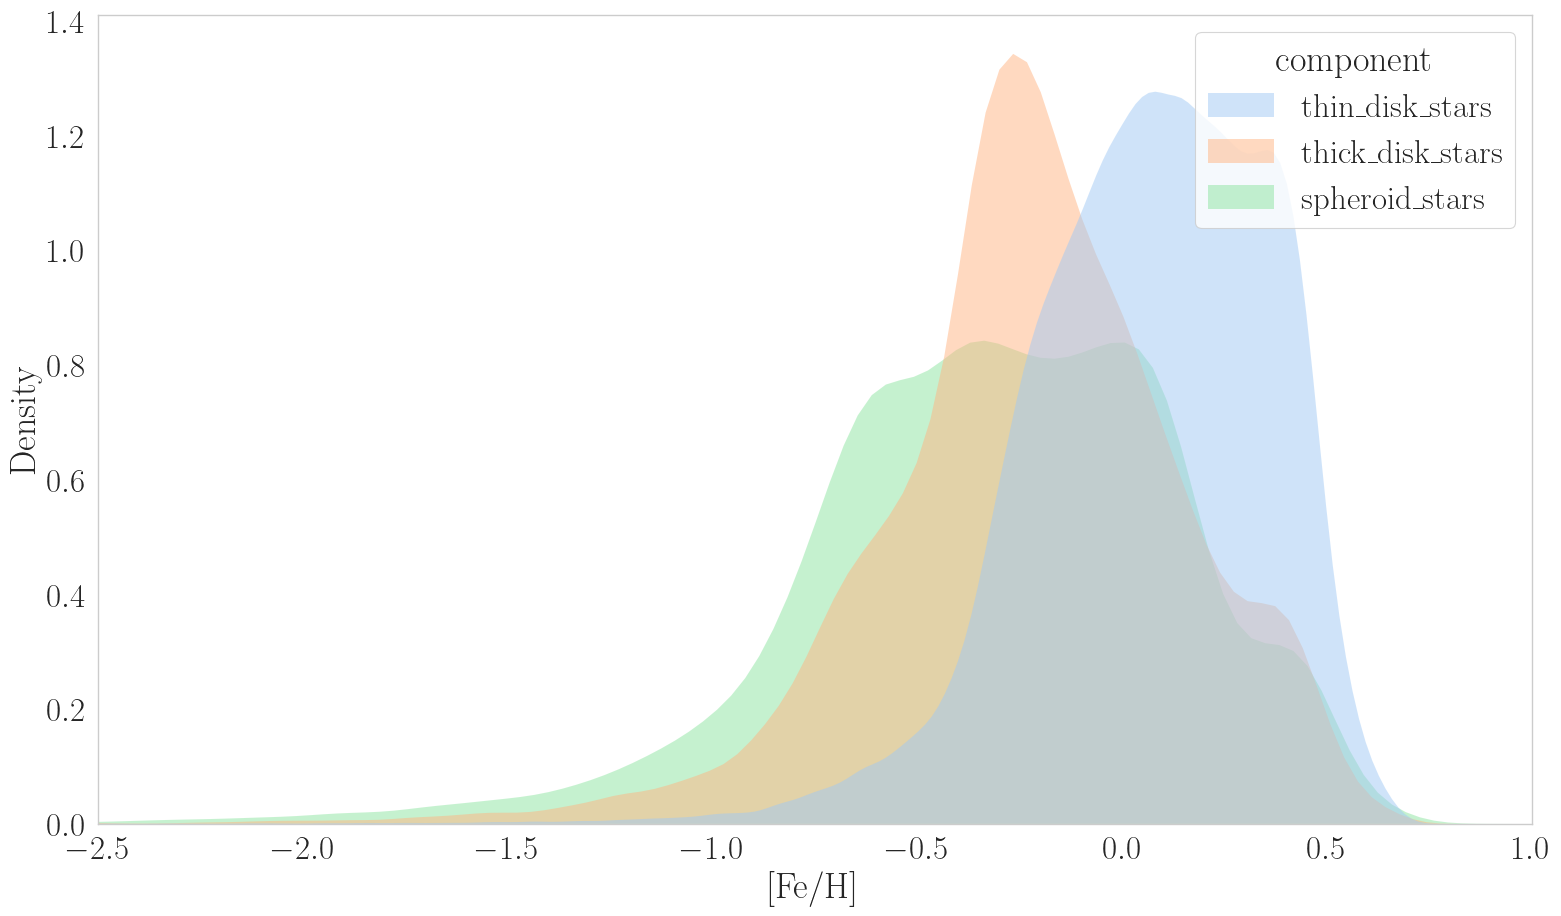

In [12]:
sns.kdeplot(
    data,
    x="[Fe/H]",
    hue="component",
    common_norm=False,
    fill=True,
    alpha=0.5,
    linewidth=0,
    gridsize=1000,
)
plt.xlim(-2.5, 1)

## [α/Fe] - [Fe/H] DIAGRAM

In [13]:
import pandas as pd
import seaborn as sns

data = get_columns("[Fe/H]")
data["[alpha/Fe]"] = get_columns("[alpha/Fe]")["[alpha/Fe]"]
data = data[data["[Fe/H]"].between(-3, 1) & data["[alpha/Fe]"].between(-0.05, 0.3)]

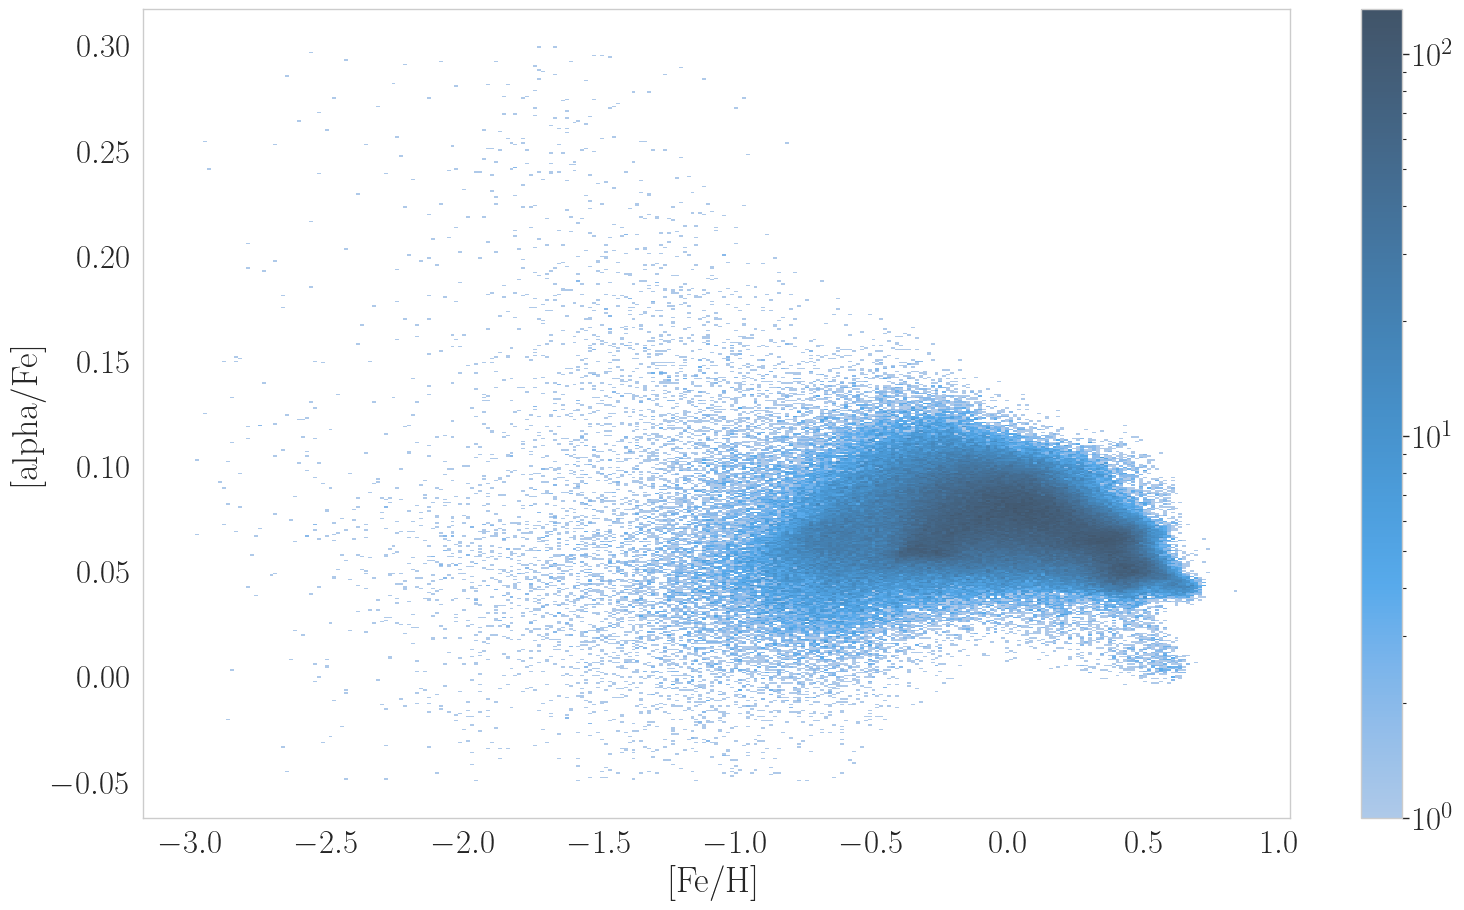

In [14]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
ax = sns.histplot(
    data[~(data["component"] == "spheroid")],
    x="[Fe/H]",
    y="[alpha/Fe]",
    cbar=True,
    norm=LogNorm(),
    vmin=None,
    vmax=None,
)